In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the data
data = pd.read_csv('/Users/xinyue/Desktop/Project 2/North Eastern.csv')
# Identify columns with dates and create new names
date_columns = [col for col in data.columns if "Unnamed" not in col]
new_columns = ['Region', 'Suburb']  # assuming the first two unnamed columns are region and suburb identifiers

# Loop through date columns and append Count and Median with respective date
for i, date in enumerate(date_columns):
    count_index = 2 * i + 83  # Adjust based on your specific pattern
    median_index = 2 * i + 85  # Adjust based on your specific pattern
    new_columns.append(f'Count {date}')
    new_columns.append(f'Median {date}')

# Set new column names to the DataFrame
data.columns = new_columns

# Save the DataFrame with new column names (optional)
# output_path = '/path_to_your_data/renamed_columns_data.csv'
# data.to_csv(output_path, index=False)

# Display the first few rows to check the new column names
print(data.head())

                    Region                              Suburb Count Mar 2010  \
0  North Eastern Melbourne  Bundoora-Greensborough-Hurstbridge          2,156   
1                      NaN         Eltham-Research-Montmorency            665   
2                      NaN                Fairfield-Alphington            518   
3                      NaN          Heidelberg-Heidelberg West            970   
4                      NaN                Ivanhoe-Ivanhoe East            520   

  Median Mar 2010 Count Jun 2010 Median Jun 2010 Count Sep 2010  \
0         $322.00          2,243         $330.00          2,363   
1         $340.00            677         $340.00            694   
2         $300.00            545         $310.00            570   
3         $320.00            950         $330.00            992   
4         $350.00            534         $350.00            539   

  Median Sep 2010 Count Dec 2010 Median Dec 2010  ... Count Mar 2019  \
0         $335.00          2,402      

In [2]:
# Filtering and renaming columns that contain 'Median'
median_columns = [col for col in data.columns if 'Median' in col]

date_parts = [col.split(' ')[1:] for col in median_columns]  # This splits "Median Mar 2010" into ["Mar", "2010"]
dates = [' '.join(date) for date in date_parts]  # This joins them back to "Mar 2010"

# Rename columns to only have the date as the column name
data.rename(columns=dict(zip(median_columns, dates)), inplace=True)

# Include suburb and region columns
useful_columns = ['Region', 'Suburb'] + dates
data = data[useful_columns]
print(data)

                     Region                              Suburb Mar 2010  \
0   North Eastern Melbourne  Bundoora-Greensborough-Hurstbridge  $322.00   
1                       NaN         Eltham-Research-Montmorency  $340.00   
2                       NaN                Fairfield-Alphington  $300.00   
3                       NaN          Heidelberg-Heidelberg West  $320.00   
4                       NaN                Ivanhoe-Ivanhoe East  $350.00   
5                       NaN                    Mill Park-Epping  $320.00   
6                       NaN                           Northcote  $390.00   
7                       NaN                             Preston  $330.00   
8                       NaN                           Reservoir  $290.00   
9                       NaN                    Thomastown-Lalor  $290.00   
10                      NaN                           Thornbury  $300.00   
11                      NaN                          Whittlesea  $325.00   
12          

In [3]:
# Reshape the data
melted_data = data.melt(id_vars='Suburb', var_name='Date', value_name='Median Price')

# Convert 'Date' to datetime
melted_data['Date'] = pd.to_datetime(melted_data['Date'], format='%b %Y', errors='coerce')

# Sort data
melted_data.sort_values(by=['Suburb', 'Date'], inplace=True)
print(melted_data)

                                 Suburb       Date Median Price
13   Bundoora-Greensborough-Hurstbridge 2010-03-01      $322.00
26   Bundoora-Greensborough-Hurstbridge 2010-06-01      $330.00
39   Bundoora-Greensborough-Hurstbridge 2010-09-01      $335.00
52   Bundoora-Greensborough-Hurstbridge 2010-12-01      $340.00
65   Bundoora-Greensborough-Hurstbridge 2011-03-01      $340.00
..                                  ...        ...          ...
505                          Whittlesea 2019-06-01      $380.00
518                          Whittlesea 2019-09-01      $380.00
531                          Whittlesea 2019-12-01      $390.00
544                          Whittlesea 2023-03-01      $440.00
11                           Whittlesea        NaT          NaN

[546 rows x 3 columns]


In [4]:
# Convert all median price columns to floats and handle potential formatting issues
for col in data.columns[2:]:  # Assuming the first two columns are 'Region' and 'Suburb'
    data[col] = pd.to_numeric(data[col].str.replace('$', '').replace(',', ''), errors='coerce')

# Reshape the data
melted_data = data.melt(id_vars=['Suburb'], var_name='Date', value_name='Median Price')

# Convert 'Date' to datetime
melted_data['Date'] = pd.to_datetime(melted_data['Date'], format='%b %Y', errors='coerce')

# Remove any rows with missing data, particularly in 'Date' or 'Median Price'
melted_data.dropna(subset=['Date', 'Median Price'], inplace=True)

# Ensure 'Median Price' is a float
melted_data['Median Price'] = melted_data['Median Price'].astype(float)
print(melted_data)

                                 Suburb       Date  Median Price
13   Bundoora-Greensborough-Hurstbridge 2010-03-01         322.0
14          Eltham-Research-Montmorency 2010-03-01         340.0
15                 Fairfield-Alphington 2010-03-01         300.0
16           Heidelberg-Heidelberg West 2010-03-01         320.0
17                 Ivanhoe-Ivanhoe East 2010-03-01         350.0
..                                  ...        ...           ...
541                           Reservoir 2023-03-01         405.0
542                    Thomastown-Lalor 2023-03-01         385.0
543                           Thornbury 2023-03-01         430.0
544                          Whittlesea 2023-03-01         440.0
545                         Group Total 2023-03-01         430.0

[533 rows x 3 columns]


# Generate future 3 years growth rates using ARIMA model 

Processing Bundoora-Greensborough-Hurstbridge


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

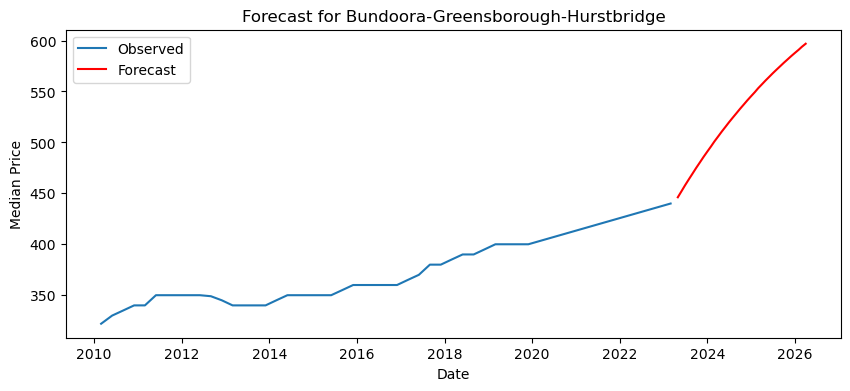

Processing Eltham-Research-Montmorency


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

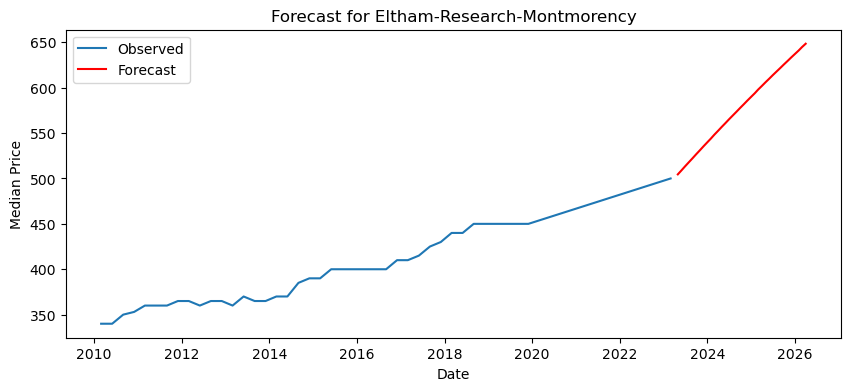

Processing Fairfield-Alphington


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

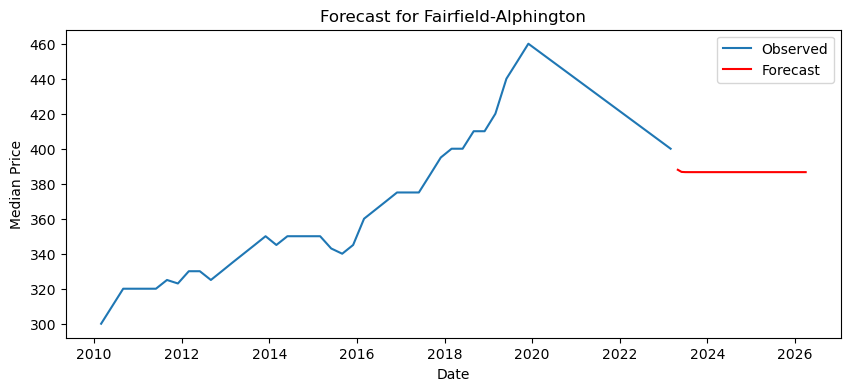

Processing Group Total


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

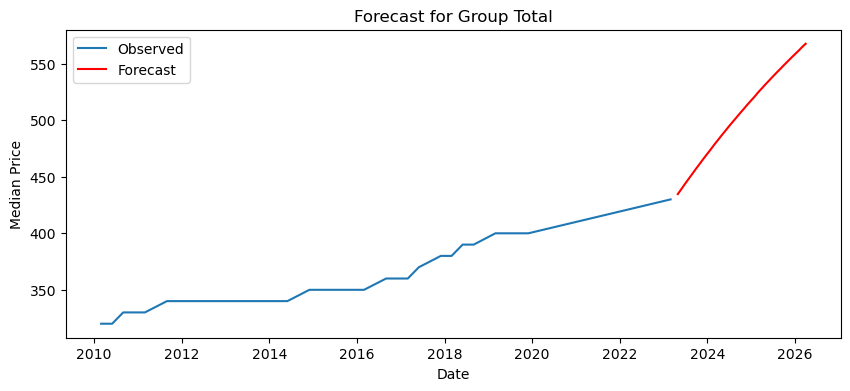

Processing Heidelberg-Heidelberg West


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

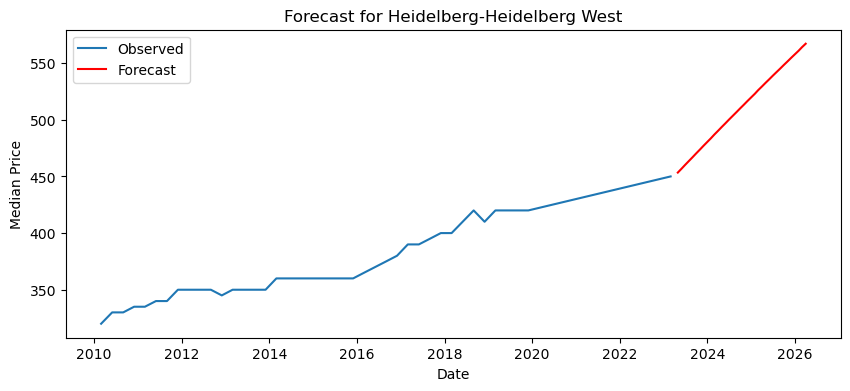

Processing Ivanhoe-Ivanhoe East


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

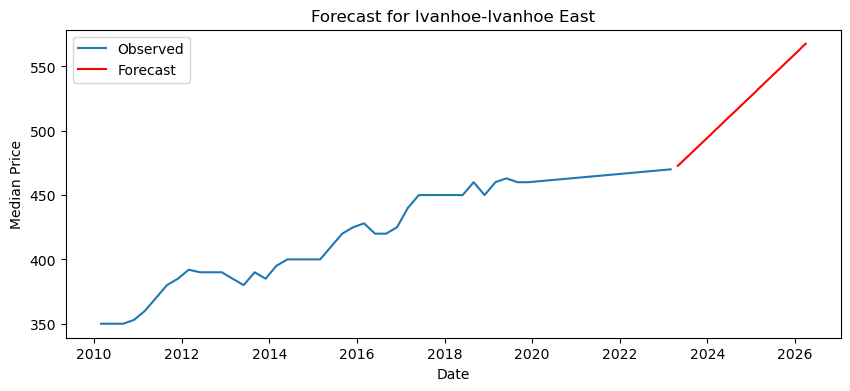

Processing Mill Park-Epping


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

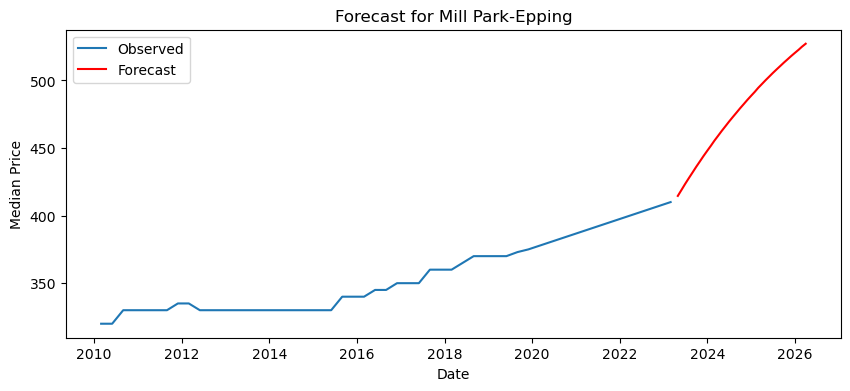

Processing Northcote


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

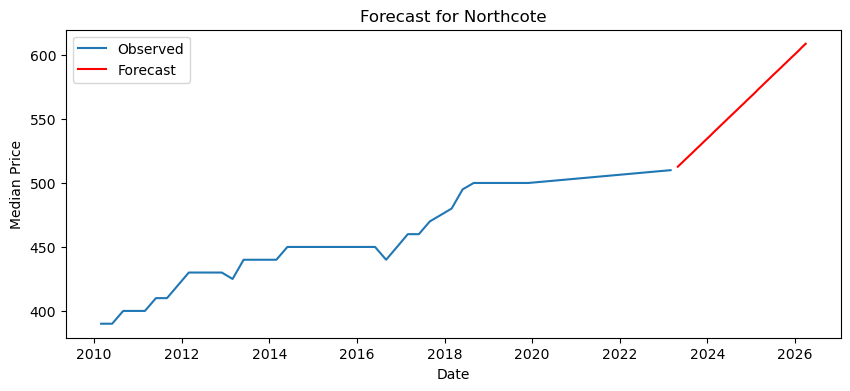

Processing Preston


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

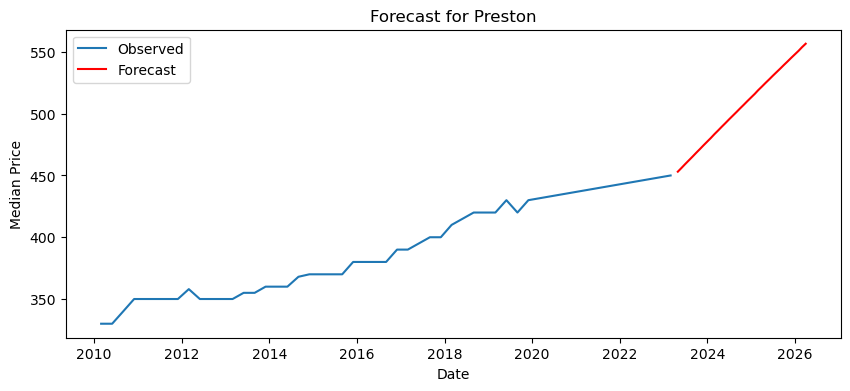

Processing Reservoir


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

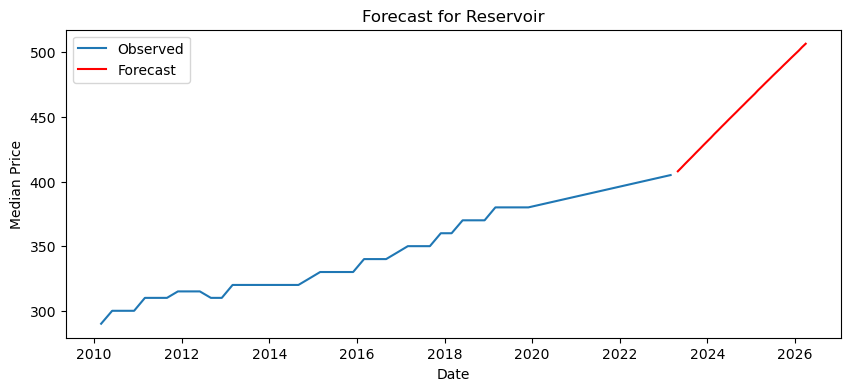

Processing Thomastown-Lalor


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

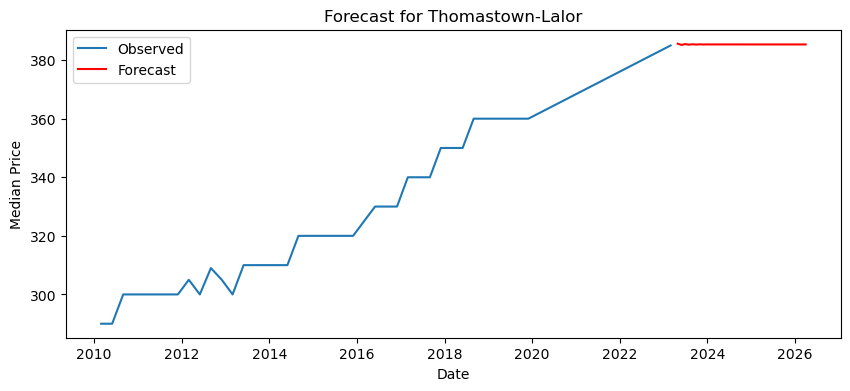

Processing Thornbury


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

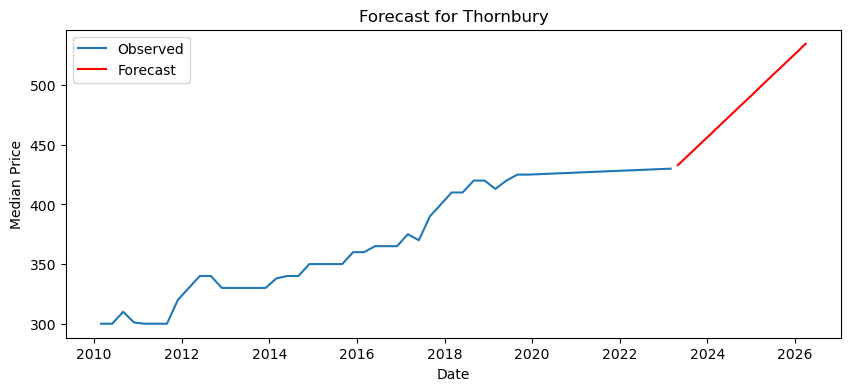

Processing Whittlesea


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

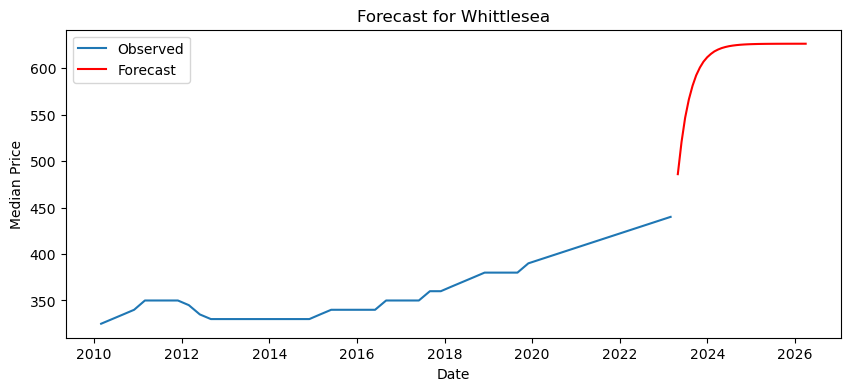

In [5]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

grouped = melted_data.groupby('Suburb')

# Loop through each suburb
for suburb, group in grouped:
    print(f"Processing {suburb}")
    try:
        # Ensure there are enough data points to model
        if len(group) > 20:
            # Ensure the data is sorted by date
            group = group.sort_values(by='Date')
            
            # Fit ARIMA model (consider optimizing the order based on ACF/PACF plots)
            model = ARIMA(group['Median Price'], order=(1,1,1))
            model_fit = model.fit()
            
            # Forecasting for the next 36 months (3 years)
            forecast = model_fit.forecast(steps=36)
            
            # Plotting
            plt.figure(figsize=(10, 4))
            plt.plot(group['Date'], group['Median Price'], label='Observed')
            future_dates = pd.date_range(start=group['Date'].iloc[-1], periods=37, freq='M')[1:]
            plt.plot(future_dates, forecast, label='Forecast', color='red')
            plt.title(f"Forecast for {suburb}")
            plt.xlabel('Date')
            plt.ylabel('Median Price')
            plt.legend()
            plt.show()
            
    except Exception as e:
        print(f"Failed to fit model for {suburb}: {e}")

# Training ARIMA model base on data from 2010 to 2016 and testing the data from 2017 to 2019 and 2023. 

Processing Bundoora-Greensborough-Hurstbridge


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

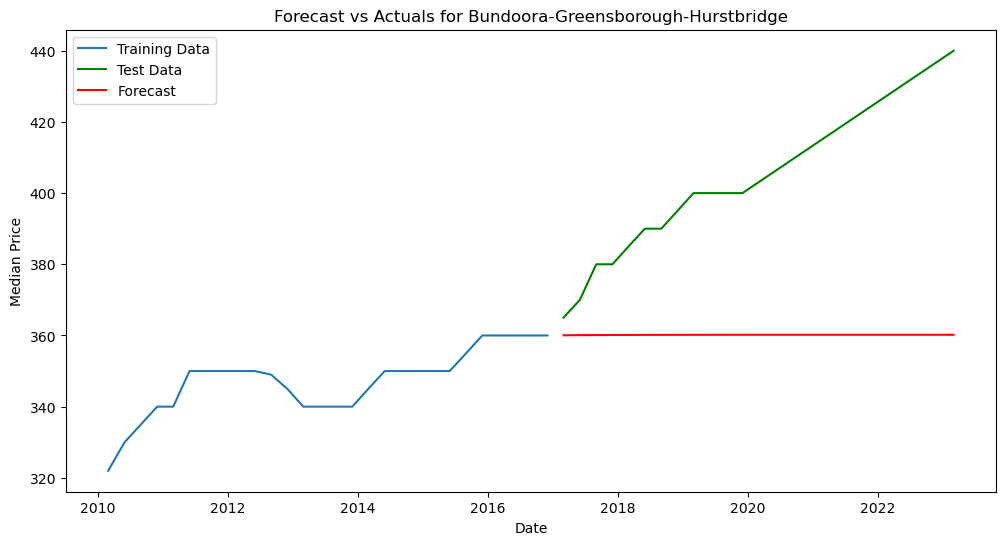

Processing Eltham-Research-Montmorency


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

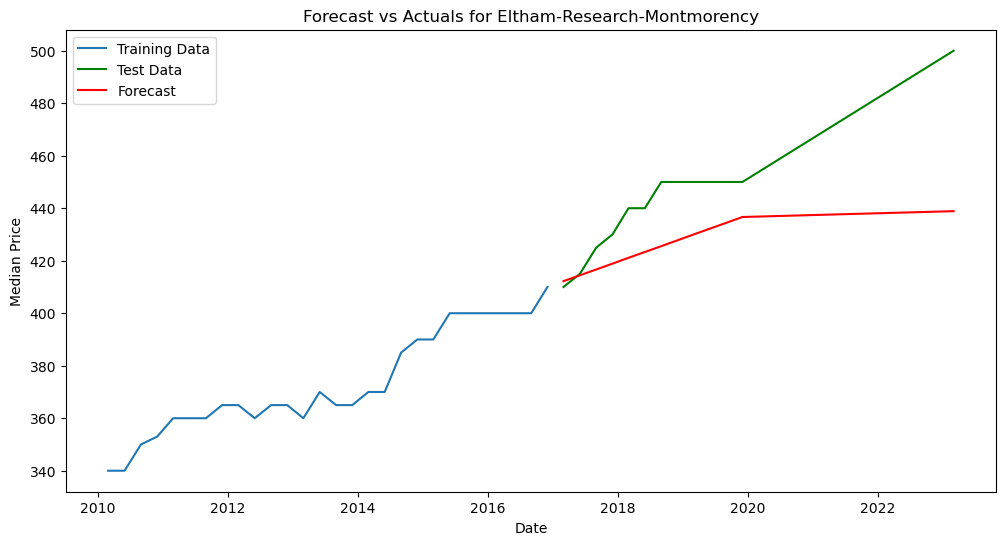

Processing Fairfield-Alphington


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

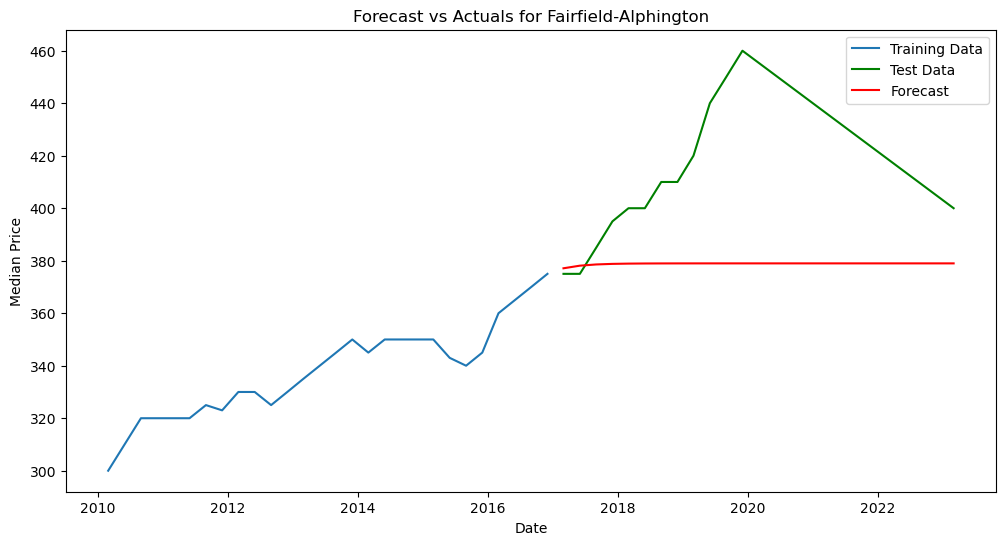

Processing Group Total


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

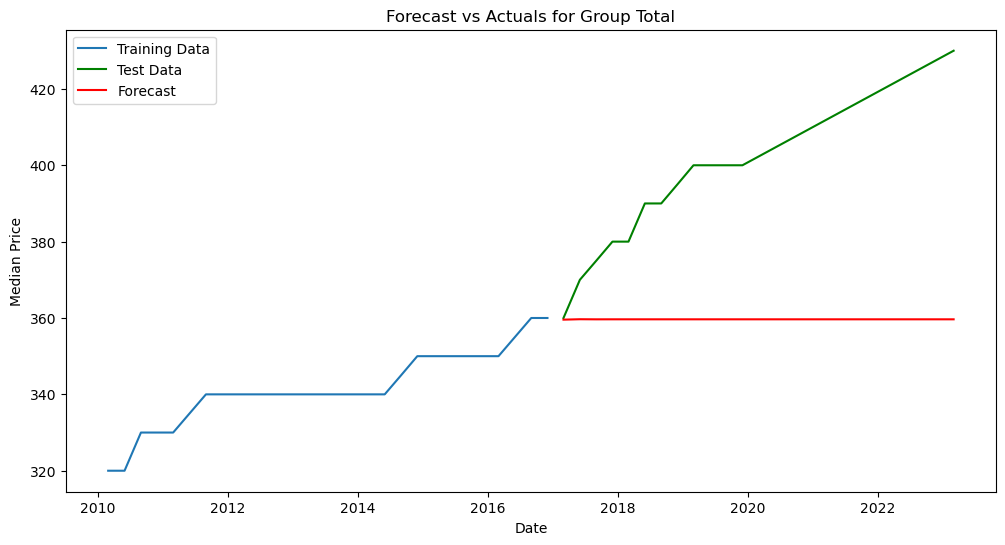

Processing Heidelberg-Heidelberg West


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

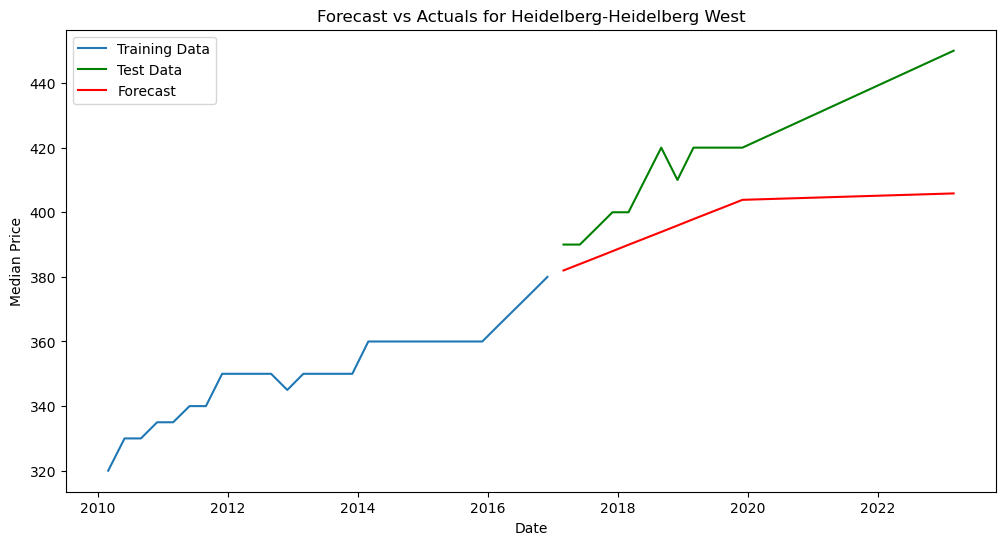

Processing Ivanhoe-Ivanhoe East


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

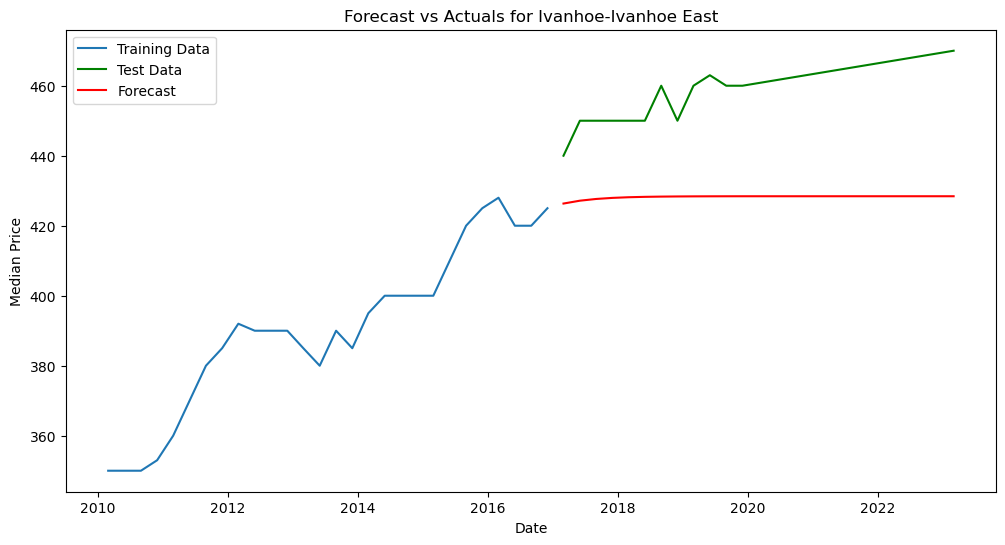

Processing Mill Park-Epping


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

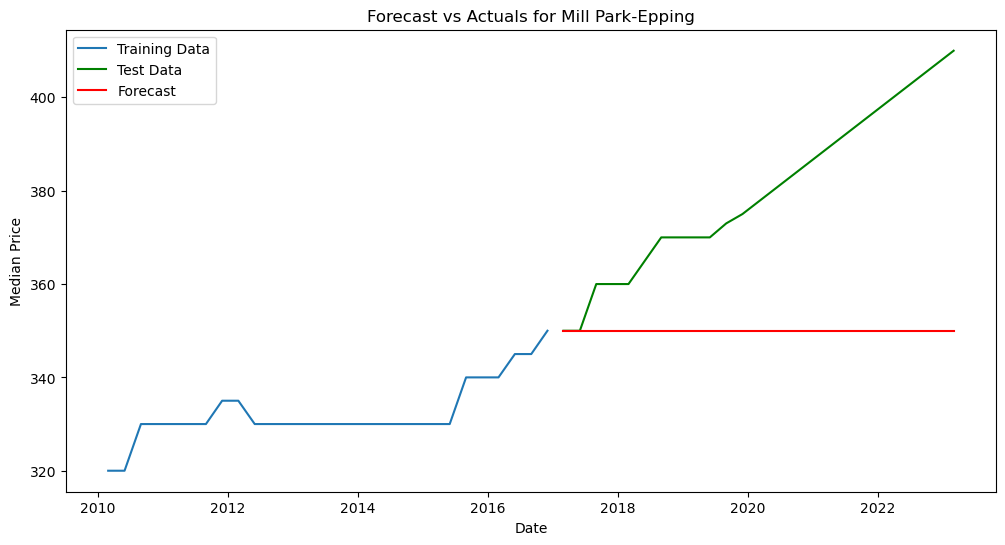

Processing Northcote


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

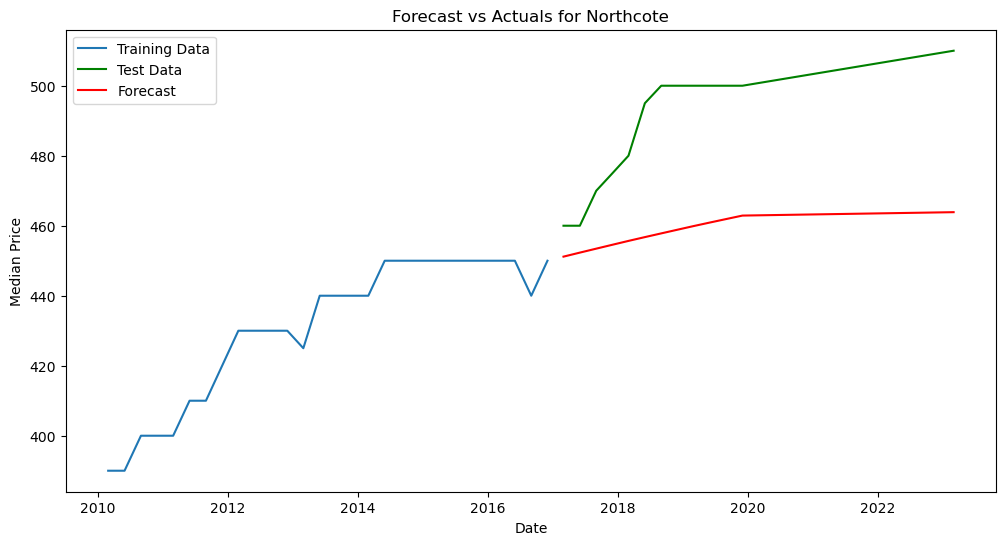

Processing Preston


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/xinyue/opt/anaconda3/

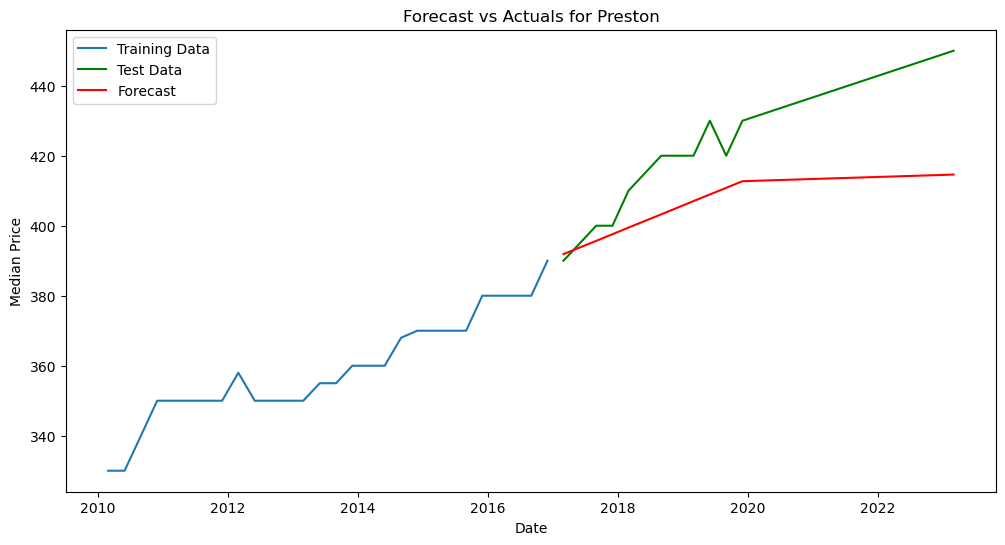

Processing Reservoir


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

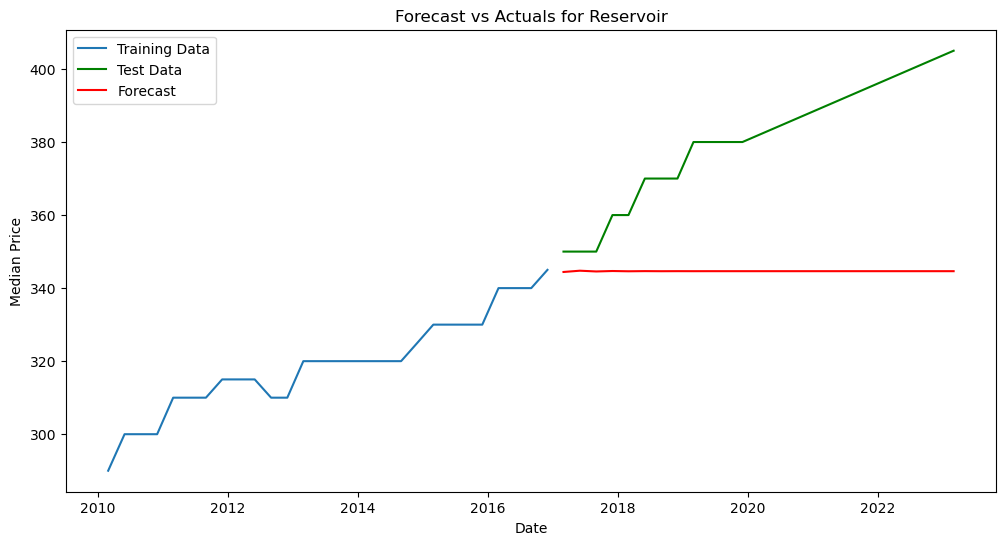

Processing Thomastown-Lalor


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

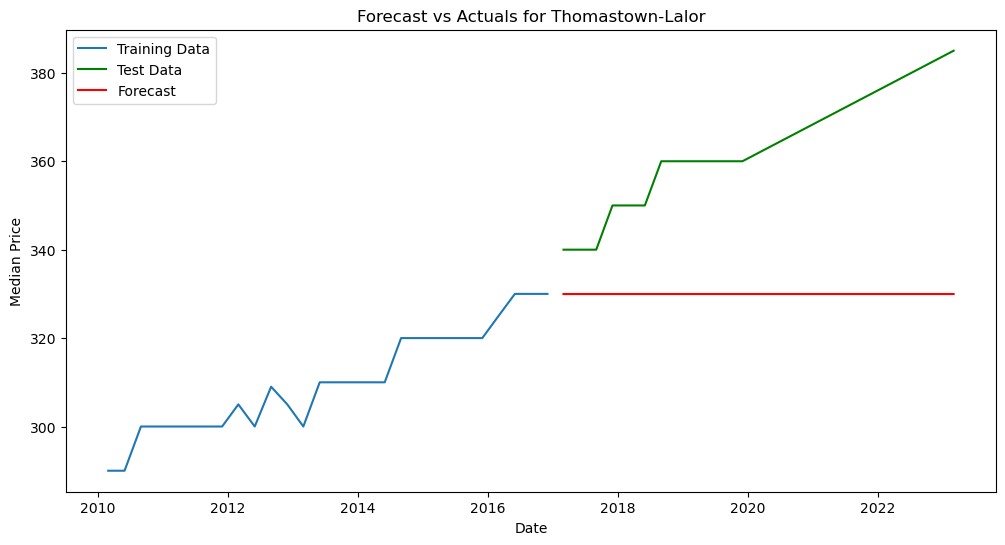

Processing Thornbury


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

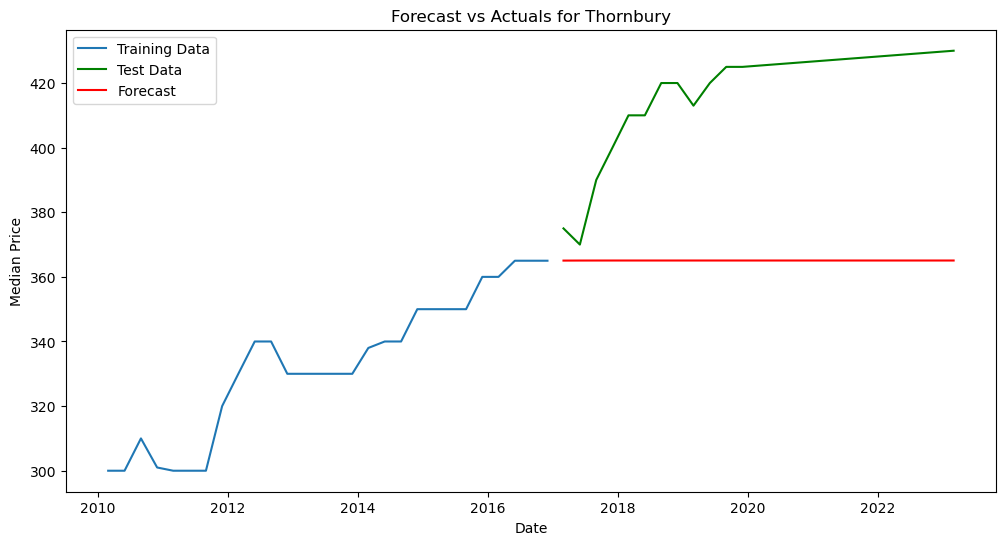

Processing Whittlesea


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

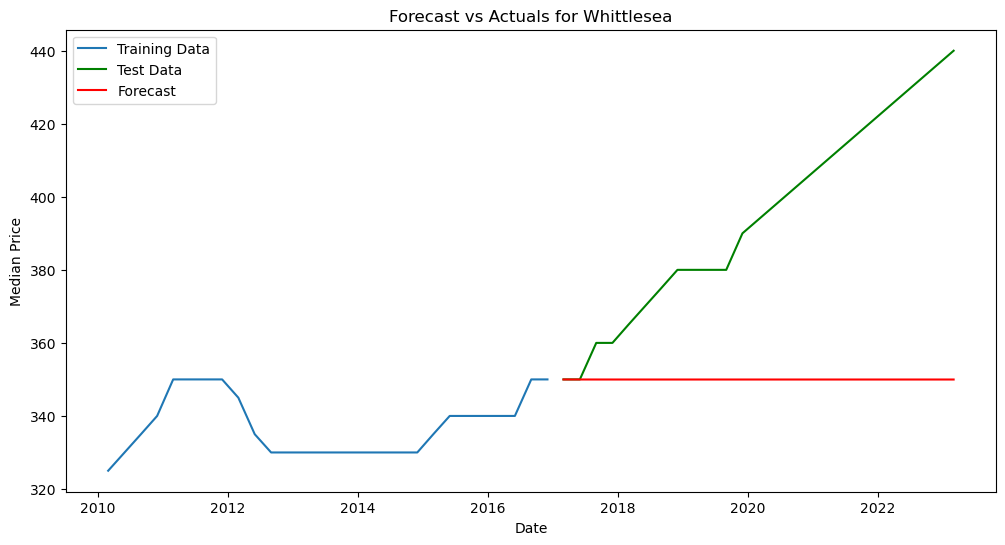

Top 10 Suburbs with the Highest Predicted Growth Rates:
Eltham-Research-Montmorency: 6.47%
Heidelberg-Heidelberg West: 6.24%
Preston: 5.80%
Northcote: 2.82%
Fairfield-Alphington: 0.50%
Ivanhoe-Ivanhoe East: 0.49%
Reservoir: 0.06%
Bundoora-Greensborough-Hurstbridge: 0.04%
Group Total: 0.02%
Thornbury: 0.01%


In [6]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Group data by suburb
grouped = melted_data.groupby('Suburb')

# Dictionary to hold the last actual median price and the last forecasted price
growth_rates = {}

for suburb, group in grouped:
    print(f"Processing {suburb}")
    try:
        # Splitting the data based on date
        train = group[group['Date'] <= pd.Timestamp('2016-12-31')]
        test = group[group['Date'] > pd.Timestamp('2016-12-31')]

        # Ensure there are enough data points to model
        if len(train) > 20:
            model = ARIMA(train['Median Price'], order=(1,1,1))  # Basic ARIMA model
            model_fit = model.fit()

            # Forecast
            forecast_steps = len(test)  # Dynamically determine how many steps to forecast based on available test data
            forecast = model_fit.forecast(steps=forecast_steps)

            # Plotting
            plt.figure(figsize=(12, 6))
            plt.plot(train['Date'], train['Median Price'], label='Training Data')
            plt.plot(test['Date'], test['Median Price'], label='Test Data', color='green')
            plt.plot(test['Date'], forecast, label='Forecast', color='red')
            plt.title(f"Forecast vs Actuals for {suburb}")
            plt.xlabel('Date')
            plt.ylabel('Median Price')
            plt.legend()
            plt.show()

            # Calculate predicted growth rate
            if len(forecast) > 0 and len(test) > 0:
                predicted_last = forecast.iloc[-1]
                last_actual = forecast.iloc[0]
                predicted_growth_rate = ((predicted_last - last_actual) / last_actual) * 100
                growth_rates[suburb] = predicted_growth_rate

        else:
            print(f"Not enough data points to train ARIMA model for {suburb}")

    except Exception as e:
        print(f"Failed to fit model for {suburb}: {e}")

# Now, let's print the top 10 suburbs with the highest predicted growth rates
top_10_suburbs = sorted(growth_rates, key=growth_rates.get, reverse=True)[:10]
print("Top 10 Suburbs with the Highest Predicted Growth Rates:")
for suburb in top_10_suburbs:
    print(f"{suburb}: {growth_rates[suburb]:.2f}%")

In [7]:
# Assuming 'data' is your DataFrame and 'Median Price' is the column you are forecasting
train = melted_data['Median Price'][:int(0.8 * len(data))]
test = melted_data['Median Price'][int(0.8 * len(data)):]
model = ARIMA(train, order=(1,1,1))  # Example: ARIMA model
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

In [8]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics(actual, predicted):
    """
    Calculate and return the evaluation metrics for the model.
    
    Parameters:
        actual (array-like): The actual observed values.
        predicted (array-like): The forecasted values from the model.
    
    Returns:
        dict: A dictionary containing MAE, MSE, RMSE, and MAPE.
    """
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100  # Handle cases where actual values are zero
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# Assume 'test' is your actual data and 'forecast' is the data predicted by the model
metrics = calculate_metrics(test, forecast)

# Printing the metrics
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {metrics['MAE']}")
print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']}")
print(f"Mean Absolute Percentage Error (MAPE): {metrics['MAPE']}%")

Evaluation Metrics:
Mean Absolute Error (MAE): 48.14970344928428
Root Mean Squared Error (RMSE): 63.35211569658657
Mean Absolute Percentage Error (MAPE): 11.661710647762542%
